<a href="https://colab.research.google.com/github/luigiselmi/dl_remote_sensing/blob/main/epfl_building_footprints_xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rooftop segmentation (U-Net Xception-style model)
In this notebook we implement a deep learning model for the semantic segmentation task. We will use images of rooftops extracted from satellite images. The target of the model is to classify all the pixels in an image that belong to a rooftop. The model used for the segmentation task is based on the encoder-decoder architecture.

In [1]:
import os
from pathlib import Path
from zipfile import ZipFile
import matplotlib.pyplot as plt
from skimage import io
from skimage import exposure
from skimage.io import imsave, imread
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.utils import array_to_img, load_img, img_to_array
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print('Tensorflow version: {:s}'.format(tf.__version__))
print('Keras version. {}'.format(keras.__version__))

NumPy version: 2.0.2
Tensorflow version: 2.18.0
Keras version. 3.8.0


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



## The dataset
We use the data from [Cadei et al - Detecting available rooftop area from satellite images to install photovoltaic panels](https://github.com/riccardocadei/photovoltaic-detection/tree/main) to implement a semantic segmentation model for the extraction of building footprints from satellite images. Train, validation, and test data are provided in separate zip files that contain a total of 305 RGB images and masks in binary digits, 0 and 1, as labels, in the PNG format. The size of the images is 250x250, that will be reduced to 224x224, and the resolution is 0.25x0.25 $m^2$

In [3]:
!wget -q --show-progress https://github.com/luigiselmi/dl_tensorflow/raw/refs/heads/main/data/epfl_buildings/epfl_buildings_train.zip

epfl_buildings_trai 100%[===================>]  35.27M  --.-KB/s    in 0.1s    


In [4]:
!wget -q --show-progress https://github.com/luigiselmi/dl_tensorflow/raw/refs/heads/main/data/epfl_buildings/epfl_buildings_test.zip

epfl_buildings_test 100%[===================>]   4.50M  --.-KB/s    in 0.06s   


In [5]:
!wget -q --show-progress https://github.com/luigiselmi/dl_tensorflow/raw/refs/heads/main/data/epfl_buildings/epfl_buildings_val.zip

epfl_buildings_val. 100%[===================>]   4.32M  --.-KB/s    in 0.06s   


In [6]:
DATADIR = '.'
with ZipFile(f'{DATADIR}/epfl_buildings_train.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/')

In [7]:
with ZipFile(f'{DATADIR}/epfl_buildings_test.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/')

In [8]:
with ZipFile(f'{DATADIR}/epfl_buildings_val.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}/')

The train, validation and test directories contain two subdirectories: images/ and labels/

In [9]:
p_train = Path('/content/train/')
train_paths = []
[train_paths.append(sub_folder) for sub_folder in p_train.iterdir() if sub_folder.is_dir()]
train_images_path = train_paths[1]
train_labels_path = train_paths[0]

In [10]:
p_val = Path('/content/val/')
val_paths = []
[val_paths.append(sub_folder) for sub_folder in p_val.iterdir() if sub_folder.is_dir()]
val_images_path = val_paths[1]
val_labels_path = val_paths[0]

In [11]:
p_test = Path('/content/test/')
test_paths = []
[test_paths.append(sub_folder) for sub_folder in p_test.iterdir() if sub_folder.is_dir()]
test_images_path = test_paths[1]
test_labels_path = test_paths[0]

We create lists of the images and masks in each train, validation, and test set.

In [12]:
def create_file_list(raster_path):
    """
    This function extracts the raster file paths (png images or masks) in the
    folder path and puts them in a list. The list is sorted in order to have
    each image and mask with the same index
    """
    file_list = []
    for file in os.listdir(raster_path):
        if file.endswith(".png"):
            file_list.append(os.path.join(raster_path, file))

    return sorted(file_list)

In [13]:
train_images_list = create_file_list(train_images_path)
print('Number of train images: {:d}'.format(len(train_images_list)))

Number of train images: 244


In [14]:
val_images_list = create_file_list(val_images_path)
print('Number of validation images: {:d}'.format(len(val_images_list)))

Number of validation images: 30


In [15]:
test_images_list = create_file_list(test_images_path)
print('Number of test images: {:d}'.format(len(test_images_list)))

Number of test images: 31


In [16]:
img_0 = io.imread(train_images_list[0])
print('Image shape: {}'.format(img_0.shape))

Image shape: (250, 250, 3)


We plot some images to have a look

In [17]:
def plot_raster(ax, list_images):
  index = 0
  for col in range(0, fig_cols):
    for row in range(0, fig_rows):
      img_natcol = io.imread(list_images[index])
      img_equalized = exposure.equalize_hist(img_natcol)
      ax[row, col].set_axis_off()
      ax[row, col].imshow(img_equalized)
      index += 1

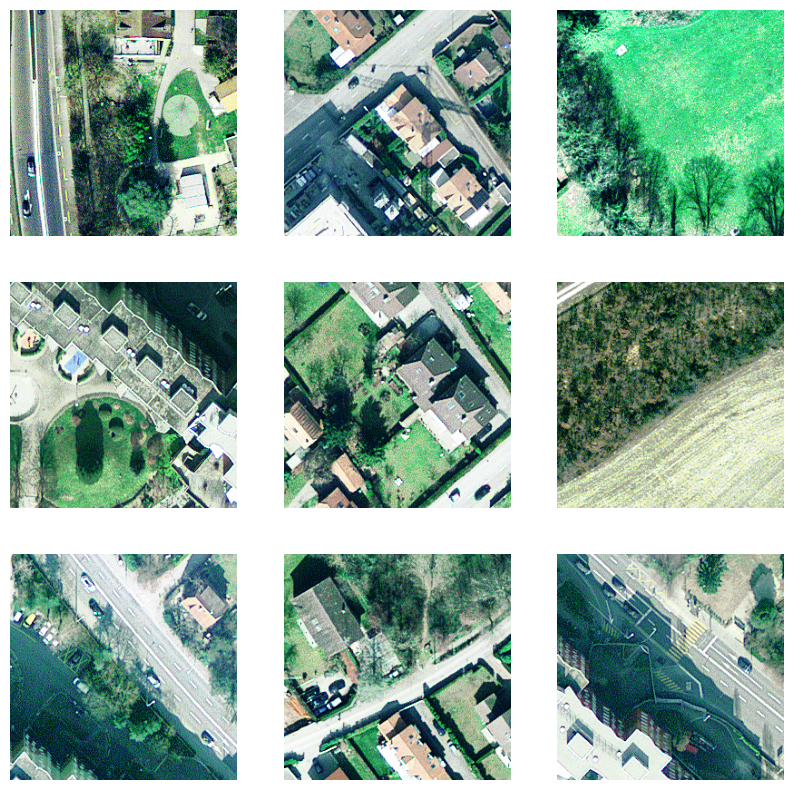

In [18]:
fig_rows = 3
fig_cols = 3
fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
plot_raster(ax, train_images_list)


We create the list of the masks for training, validation and test as well

In [19]:
train_labels_list = create_file_list(train_labels_path)
val_labels_list = create_file_list(val_labels_path)
test_labels_list = create_file_list(test_labels_path)

In [20]:
label_0 = io.imread(train_labels_list[0])
print('Mask shape: {}'.format(label_0.shape))

Mask shape: (250, 250, 3)


The binary values used in the masks are 0 and 255

In [49]:
label_0_unique = np.unique(label_0)
print('Unique values in the mask: {}'.format(label_0_unique))


Unique values in the mask: [  0 255]


We plot the masks of the images we saw before

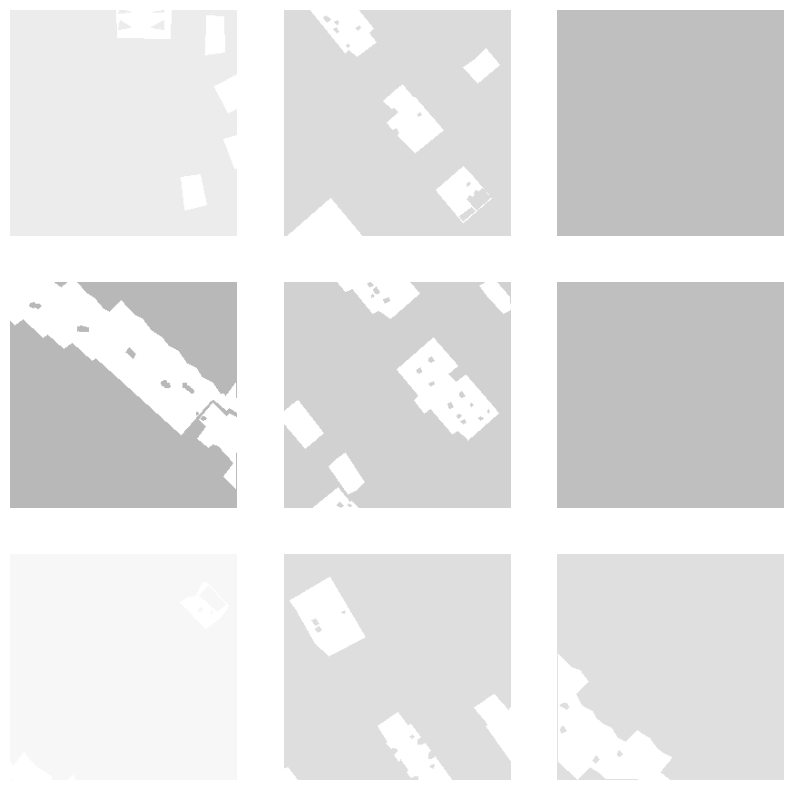

In [50]:
fig, ax = plt.subplots(nrows=fig_rows, ncols=fig_cols, figsize=(10, 10))
plot_raster(ax, train_labels_list)

## Data preparation
We load the data into Keras datasets for the training and validation. The images and masks must be converted into tensors and put in batches.

In [51]:
import random
random.Random(1337).shuffle(train_images_list)
random.Random(1337).shuffle(train_labels_list)

We load images and masks into PIL format and convert them to NumPy arrays.

In [52]:
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

In [53]:
def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 255
    return img

We create an array of 224x224 RGB images and binary masks, with values in {0, 1}, for training

In [54]:
img_size = (224, 224)
num_train_imgs = len(train_images_list)
train_input_imgs = np.zeros((num_train_imgs,) + img_size + (3,), dtype="float32")
train_targets = np.zeros((num_train_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_train_imgs):
    train_input_imgs[i] = path_to_input_image(train_images_list[i])
    train_targets[i] = path_to_target(train_labels_list[i])

In [55]:
train_input_imgs.shape, train_targets.shape

((244, 224, 224, 3), (244, 224, 224, 1))

In [81]:
label_0_unique = np.unique(train_targets[0,:,:,0])
print('Unique values in the mask: {}'.format(label_0_unique))

Unique values in the mask: [0 1]


Then an array of RGB images and binary masks for validation

In [56]:
num_val_imgs = len(val_images_list)
val_input_imgs = np.zeros((num_val_imgs,) + img_size + (3,), dtype="float32")
val_targets = np.zeros((num_val_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_val_imgs):
    val_input_imgs[i] = path_to_input_image(val_images_list[i])
    val_targets[i] = path_to_target(val_labels_list[i])

In [57]:
val_input_imgs.shape

(30, 224, 224, 3)

and finally an array of RGB images and masks for test

In [58]:
num_test_imgs = len(test_images_list)
test_input_imgs = np.zeros((num_test_imgs,) + img_size + (3,), dtype="float32")
test_targets = np.zeros((num_test_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_test_imgs):
    test_input_imgs[i] = path_to_input_image(test_images_list[i])
    test_targets[i] = path_to_target(test_labels_list[i])

In [59]:
test_input_imgs.shape

(31, 224, 224, 3)

### Data augmentation
Since the dataset is a small one we use data augmentation to increase the number of images for training

In [60]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

We can see the effect of the transformations applied to one image

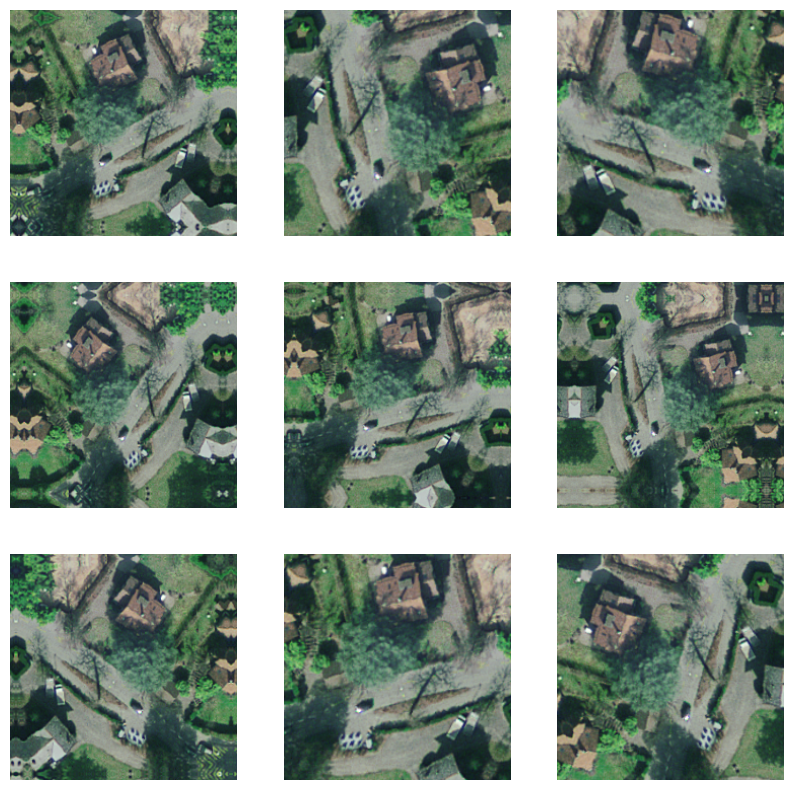

In [61]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_images = data_augmentation(train_input_imgs)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0].numpy().astype("uint8"))
  plt.axis("off")

## Building the encoder-decoder model
We use again the encoder-decoder model we used in a previous semantic segmentation task. The model includes the data augmentation step, three convolutional blocks for the downsamplig, and three transpose convolutional blocks for upsampling.

In [62]:
def build_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [68]:
model = build_model(img_size=img_size, num_classes=2)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 112, 112,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 112, 112,  │          0 │ activation_15[0]… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_6  │ (None, 112, 112,  │      2,400 │ activation_16[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_7  │ (None, 112, 112,  │      4,736 │ activation_17[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 56, 56,    │      2,112 │ activation_15[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 56, 56,    │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │ conv2d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 56, 56,    │          0 │ add_7[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_8  │ (None, 56, 56,    │      8,896 │ activation_18[0]… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 2,058,690 (7.85 MB)

 Trainable params: 2,054,914 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [69]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy") #)
              #metrics=[keras.metrics.BinaryIoU(target_class_ids=(0, 1), threshold=0.5, name=None, dtype=None)])

callbacks = [
    keras.callbacks.ModelCheckpoint("rooftop_segmentation.keras",
    save_best_only=True)
]

In [70]:
history = model.fit(train_input_imgs, train_targets,
                    epochs=100,
                    callbacks=callbacks,
                    batch_size=5,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 52s 384ms/step - loss: 2.7550 - val_loss: 0.5046
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.3401 - val_loss: 0.4825
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.2446 - val_loss: 0.4986
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.1878 - val_loss: 0.6048
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.1874 - val_loss: 0.6597
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1759 - val_loss: 0.8420
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1413 - val_loss: 0.9198
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1349 - val_loss: 1.0703
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.1192 - val_loss: 0.6021
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.1151 - val_loss: 0.9041
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.1035 - val_loss: 0.5924
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/st

In [72]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]

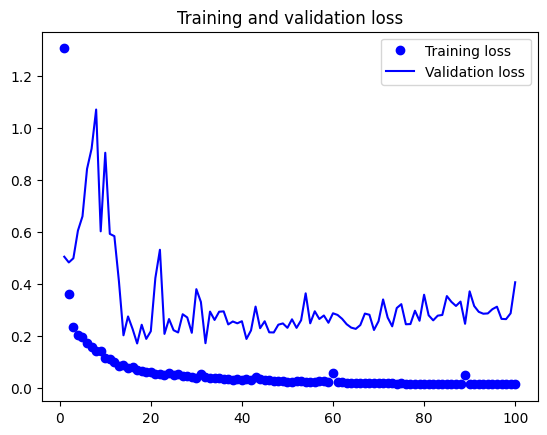

In [73]:
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [74]:
best_model = keras.models.load_model("rooftop_segmentation.keras")

In [137]:
def plot_predicted_mask(test_img, test_mask, predicted_mask):
  fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
  predicted_mask_ch1 = np.expand_dims(predicted_mask, 2)

  ax[0].axis("off")
  ax[0].set_title('Test image')
  ax[0].imshow(array_to_img(test_image))
  ax[1].axis("off")
  ax[1].set_title('Test Mask')
  ax[1].imshow(array_to_img(test_mask))
  ax[2].axis("off")
  ax[2].set_title('Predicted Mask')
  ax[2].imshow(array_to_img(predicted_mask_ch1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


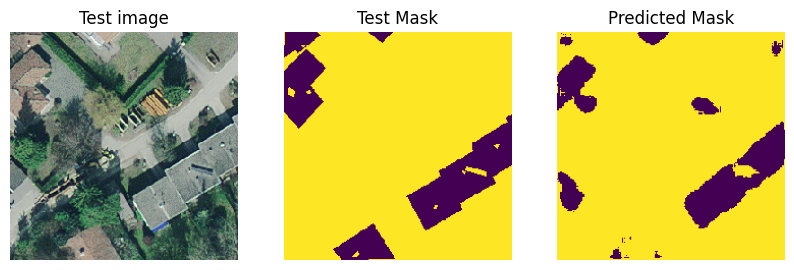

In [138]:
i = 5
test_image = test_input_imgs[i]
test_tensor = np.expand_dims(test_image, 0)
test_mask = test_targets[i]
predicted_mask_tensor = best_model.predict(test_tensor)
predicted_mask = predicted_mask_tensor[0,:,:,1]
predicted_mask[predicted_mask >= 0.5] = 1
predicted_mask[predicted_mask < 0.5] = 0
plot_predicted_mask(test_image,test_mask, predicted_mask)